# CS4305TU: Week 6 - Artificial Neural Network - Assignment
## Investigating neighbourhood choice behaviour using ANNs
**7 & 11 October 2021**

- Sander van Cranenburgh
- Francisco Garrido-Valenzuela 

### General information

* For this assignment we will use *Stated Choice data* on residential location choice, collected in:
    - Mainz, Germany
    - Hanover, Germany
    - Bern, Switzerland
    - Zurich, Switzerland 

- For more details on the data, see the description provided on [Brightspace](https://brightspace.tudelft.nl/d2l/le/content/399675/viewContent/2506146/View). 

- In total you can earn **6.0** points in this assignment. 

- Add **Code cells** to complement your analyses. You can draw a lot form the snippets of codes we used for the in-class exercises.

- 

**Provide your answers in the allocated markdown boxes** (with the red font color)


### Set up your environment

You need to set up your environment based on which platform you would like to use. In this case we offer two options:

- Google Colaboratory (Colab)
- Jupyter Lab or Notebooks (Local)

#### Using Colab

Students using **Colab**, just need to install **Biogeme**. Biogeme is a Python package designed for the maximum likelihood estimation of parametric models in general, with a special emphasis on discrete choice models. Just run the following notebook cell:

In [1]:
# Uncomment and run this cell if you are using Google Colab (keep the exclamation mark)
#!pip install biogeme
#!git clone https://github.com/cs4305tu/assignment
#root = 'assignment/'

#### Using local environment

Students using their *local environments*, need to install all the dependencies used in this *Week 6*, to ensure compatibility, they also need to check the versions of each dependency. All dependencies are contained in the text file: **requirements.txt**. Just run the following notebook cell:

In [2]:
# Uncomment and run this cell if you are using your local environment (keep the exclamation mark)
#!pip3 install -r requirements.txt
#root = ''

### Required Python packages

In the following cell add all the packages you need to finish this assignment.

In [3]:
import pandas as pd
import tensorflow as tf
print("Using tensorflow ",tf.__version__)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Dense, Activation
from keras.layers import Conv2D, Add, Reshape
from keras.models import Model
from keras.utils.np_utils import to_categorical   
import matplotlib.pyplot as plt
import numpy as np

import biogeme.biogeme as bio
import biogeme.database as db
import biogeme.optimization as opt
import biogeme.messaging as msg
from biogeme import models
from biogeme.expressions import Beta

Using tensorflow  2.6.0


### Opening the database

In [4]:
# Load the data into a dataframe
df = pd.read_csv(f'{root}datasets/neighbourhood_choice2018.dat', sep='\t')
df.head()

,ID,ID2,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,...,NOISE3,GREEN3,FOREIGN3,CHOICE,SSTADT,RESPCITY,WOMAN,AGE,ENVCONC,COMPLETE
0,2,5,10,5,1,2,2,0.4,15,10,...,4,4,0.2,1,3,3,0,42,3.0,1
1,2,6,15,5,4,4,1,0.1,2,10,...,2,3,0.3,2,3,3,0,42,3.0,1
2,2,7,10,15,1,3,1,0.4,15,2,...,1,3,0.2,3,3,3,0,42,3.0,1
3,2,8,15,15,5,4,4,0.4,2,2,...,2,2,0.2,2,3,3,0,42,3.0,1
4,3,9,15,5,5,1,3,0.4,2,10,...,3,1,0.2,2,2,2,1,41,4.5,1


## Questions

### Q1. Do a proper descriptive analysis of the data set (1.0 pt)

It is good practice do a descriptive analysis of the data you want to model, prior to the real modelling. So inspect e.g. what levels the attributes (features) take, correlations, class (im)balances, redudant variables, missing values, etc. to attain a good feeling for the data.

Attribute levels for STORES [min] =  [ 2  5 10 15]
Attribute levels for TRANSPORT [min] =  [ 2  5 10 15]
Attribute levels for CITY [km] =  [1 2 4 5]
Attribute levels for NOISE =  [1 2 3 4]
Attribute levels for GREEN =  [1 2 3 4]
Attribute levels for FOREIGN [%/100] =  [0.1 0.2 0.3 0.4]
[1 2 3] [3440 3266 3014]


Text(0, 0.5, 'Frequency')

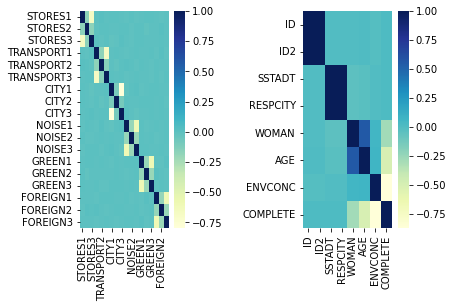

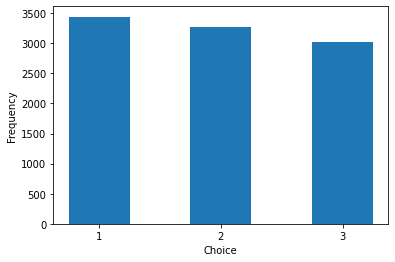

In [5]:
# Attribute levels
print('Attribute levels for STORES [min] = ',np.unique(df[['STORES1', 'STORES2','STORES3']].values))
print('Attribute levels for TRANSPORT [min] = ',np.unique(df[['TRANSPORT1', 'TRANSPORT2','TRANSPORT3']].values))
print('Attribute levels for CITY [km] = ',np.unique(df[['CITY1', 'CITY2','CITY3']].values))
print('Attribute levels for NOISE = ',np.unique(df[['NOISE1', 'NOISE2','NOISE3']].values))
print('Attribute levels for GREEN = ',np.unique(df[['GREEN1', 'GREEN2','GREEN3']].values))
print('Attribute levels for FOREIGN [%/100] = ',np.unique(df[['FOREIGN1', 'FOREIGN2','FOREIGN3']].values))

# Correlations between attribute levels
import seaborn as sb
plt.figure(1)
plt.subplot(121)
plot1 = sb.heatmap(df[['STORES1', 'STORES2','STORES3','TRANSPORT1', 'TRANSPORT2','TRANSPORT3','CITY1', 'CITY2','CITY3','NOISE1', 'NOISE2','NOISE3','GREEN1', 'GREEN2','GREEN3','FOREIGN1', 'FOREIGN2','FOREIGN3']].corr(), cmap="YlGnBu", annot=False)

# Correlations between covariates
plt.subplot(122)
plot2 = sb.heatmap(df[['ID','ID2','SSTADT','RESPCITY','WOMAN','AGE','ENVCONC','COMPLETE']].corr(), cmap="YlGnBu", annot=False)
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace = 1)

unique, counts = np.unique(df[['CHOICE']], return_counts=True)
print(unique,counts)

# Show how often each alternative is chosen
plt.figure(2)
plt.hist(df.CHOICE, bins = [0.75, 1.25, 1.75, 2.25, 2.75, 3.25])
plt.xticks((1, 2, 3))
plt.xlabel('Choice')
plt.ylabel('Frequency')

<font color='red'>

**ANSWER Q1** <br>
...

### Q2. Estimate a RUM-MNL discrete choice model (1.0 pt)

Assume utility is linear additive-utility: 

$ V_{in} = \sum_{m}\beta_m x_{imn}$

And estimate marginal utilities (i.e. betas) for: 

1. Distance to Transport [min] (**Note** that distances are given in minutes)
2. Distance to City [km]
3. Distance to Stores [min] (**Note** that distances are given in minutes)
4. Traffic Noise
5. Green area
6. Share of foreigners [%]

**Note:** Do not add any other variables (features) to the model.

**To get the scores, address the following:**

- (A) Report the parameter estimates, and interpret them. i.e. do they have the expected sign? (0.5 pts)
- (B) Compute and report the cross-entropy (0.5 pts)

In [6]:
database = db.Database('Dataset CS4305TU assignment', df)

# The following statement allows you to use the names of the variable as Python variables.
globals().update(database.variables)

B_distTransport = Beta('B_distTransport', 0, None, None, 0)
B_distCity = Beta('B_distCity', 0, None, None, 0)
B_distStores = Beta('B_distStores', 0, None, None, 0)
B_Noise = Beta('B_Noise', 0, None, None, 0)
B_Green = Beta('B_Green', 0, None, None, 0)
B_shareForeign = Beta('B_shareForeign', 0, None, None, 0)

# Utility functions
V1 = B_distTransport * TRANSPORT1 + B_distCity * CITY1 + B_distStores * STORES1 + B_Noise * NOISE1 + B_Green * GREEN1 + B_shareForeign * FOREIGN1
V2 = B_distTransport * TRANSPORT2 + B_distCity * CITY2 + B_distStores * STORES2 + B_Noise * NOISE2 + B_Green * GREEN2 + B_shareForeign * FOREIGN2
V3 = B_distTransport * TRANSPORT3 + B_distCity * CITY3 + B_distStores * STORES3 + B_Noise * NOISE3 + B_Green * GREEN3 + B_shareForeign * FOREIGN3

# Associate utility functions with the numbering of alternatives in df.CHOICE
V = {1: V1, 2: V2, 3: V3}

# Associate the availability conditions with the alternatives
av = {1: 1, 2: 1, 3: 1}

# Definition of the model. This is the contribution of each observation to the log likelihood function.
prob = models.loglogit(V, av, CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, prob)
biogeme.modelName = 'My first discrete choice model'
biogeme.generatePickle = False
biogeme.generateHtml = False

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results = biogeme.estimate()

# Report the results in a pandas table
print('Estimated parameters')
print('----------')
pandasResults = results.getEstimatedParameters()
print(pandasResults[['Value','Std err','t-test','p-value']])

# Compute cross entropy
estimation_results = results.getGeneralStatistics()
LL_dcm = estimation_results.get('Final log likelihood')
cross_entropy_DCM = -(LL_dcm[0])/len(df)
print('Cross entropy of the DCM is', "{:.3f}".format(cross_entropy_DCM ))

Estimated parameters
----------
                    Value   Std err     t-test  p-value
B_Green          0.415892  0.011616  35.802456      0.0
B_Noise         -0.437467  0.011335 -38.594237      0.0
B_distCity      -0.167376  0.007949 -21.055686      0.0
B_distStores    -0.034432  0.002577 -13.364003      0.0
B_distTransport -0.073961  0.002548 -29.025833      0.0
B_shareForeign  -1.195431  0.109407 -10.926467      0.0
Cross entropy of the DCM is 0.889


<font color='red'>

**ANSWER Q2** <br>

The signs of the parameters tell us that: <br>
* More Green area is preferred over less Green area (as expected) <br>
* Less Noise area is preferred over more Noise (as expected)<br>
* Living nearer to the city centre/ grocery stores / Public transport / is preferred over living further away from them (as expected)<br>
* A smaller share of foreigners is preferred over a larger share of foreigners<br>
<br>
Overall, all parameters are in line with expectations<br>
<br>
The cross entropy for the DCM is = 0.889

### Q3. Based on your results, compute the WtP of the average decision maker to reduce the share of foreigners in a neighbourhood by 1 percentage point in terms of the distance to the grocery stores (0.5 pts)

Thus, the answer must be of the following form: .... [minutes/percentage point].


In [7]:
print('Willingness-to-Pay estimates')
betas = results.getBetaValues()
WtP_shareForeign_stores = betas['B_shareForeign']/(betas['B_distStores']*100)
WtP_shareForeign_city   = betas['B_shareForeign']/(betas['B_distCity']*100)
print('The willingness to pay to reduce the share of foreigners by 1 percentage point = ',  "{:.3f}".format(WtP_shareForeign_stores),'minutes')
# print('The willingness to pay to reduce the share of foreigners by 1 percentage point = ',  "{:.3f}".format(WtP_shareForeign_city),'kilometre')

Willingness-to-Pay estimates
The willingness to pay to reduce the share of foreigners by 1 percentage point =  0.347 minutes


<font color='red'>

**ANSWER Q3** <br>
...

### Q4. Train a hybrid RUM-MNL-ANN model (1.5 pts)

Since we are interested in the WtP of Q3, make sure when building the hybrid model to place the features of the share of foreigners and of the distance to the grocery stores in the *MNL part of the model*. For the *ANN part of the model* use 2 hidden layers, with 5 nodes each. 


**To get the scores, address the following:**


- (A) Build the model, plot the loss as a function of the epochs & report the cross entropy of your final model based on the test data. (1.0 pt)
- (B) Compare the model performance to that of the discrete choice model. Interpret the result. (0.5 pts)

In [8]:
# Define the features and the output class
X = df[['STORES1','TRANSPORT1','CITY1','NOISE1','GREEN1','FOREIGN1','STORES2','TRANSPORT2','CITY2','NOISE2','GREEN2','FOREIGN2','STORES3','TRANSPORT3','CITY3','NOISE3','GREEN3','FOREIGN3','SSTADT','WOMAN','AGE','ENVCONC']]
# print(X.head)

# Define the output target
Y = df['CHOICE']
Y_cat = to_categorical(Y-1, num_classes = 3)

In [9]:
NALT = 3           # Number of alterantives in the data set.
no_X_MNL =   2     # Number of attributes with behavioural interest (-->MNL model part).  In this example we are particularly interested in the WtP for extra storage space --> Cost & Storage
no_X_ANN = 3*4+4   # Number of features without behavioural interest (-->ANN model part). In this example we are not behaviourall interested in Camera, Size, and the socio demographic variables
num_nodes = 5      # Number of nodes in hidden layer(s). Again we use 2 hidden layers with *num_nodes* nodes each
nEpoch = 20        # Number epochs for training (max). 

In [10]:
# INPUT FOR MNL PART
X_MNL = Input((no_X_MNL, NALT,1), name = 'Features2MNL')

# COMPUTE UTILITY FOR MNL
V_MNL = Conv2D(filters = 1, kernel_size = [no_X_MNL,1], strides = (1,1), padding = 'valid', name = 'MNL_layer', use_bias = False, trainable = True)(X_MNL)

2021-09-28 17:28:27.002753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# INPUT FOR ANN PART
X_ANN = Input((no_X_ANN), name ='Features2ANN')

# CREATE HIDDEN LAYER(S) OF ANN
layer1_ANN = Dense(units = num_nodes, name = "ANN_layer1", use_bias = True)(X_ANN)      
layer2_ANN = Dense(units = num_nodes, name = "ANN_layer2", use_bias = True)(layer1_ANN)

# COMPUTE UTILITY FOR ANN 
V_ANN = Dense(units = NALT, name = "V_ANN")(layer2_ANN) 

In [12]:
# RESHAPE TENSORS TO [1 X NALT]
V_MNL = Reshape([NALT], name = 'Flatten_Dim_MNL')(V_MNL)
V_ANN = Reshape([NALT], name = 'Flatten_Dim_ANN')(V_ANN) 

# SUM THE UTILITIES OF BOTH MODEL PARTS
V_MNL_ANN = Add(name = "Combining_Vs")([V_MNL,V_ANN])

# CREATE LOGIT (AKA SOFTMAX ) OUTPUT LAYER
logits = Activation('softmax', name = 'Probability')(V_MNL_ANN)

# BUILD THE MODEL
model = Model(inputs = [X_MNL, X_ANN], outputs = logits)

In [13]:
scale = 1

# Create x input for MNL layer, and rescale
x_mnl = np.array([[np.divide(X['STORES1'], scale), np.divide(X['FOREIGN1'], scale)],
                  [np.divide(X['STORES2'], scale), np.divide(X['FOREIGN2'], scale)],
                  [np.divide(X['STORES3'], scale), np.divide(X['FOREIGN3'], scale)]])
x_mnl = np.swapaxes(x_mnl, 0, 2)
x_mnl = np.expand_dims(x_mnl, 3)
print('Shape of x_mnl', x_mnl.shape)

# Create x input for ANN layer
x_ann = np.array([[X['CITY1'], X['TRANSPORT1'],X['NOISE1'],X['GREEN1'], X['CITY2'], X['TRANSPORT2'],X['NOISE2'],X['GREEN2'],X['CITY3'], X['TRANSPORT3'],X['NOISE3'],X['GREEN3'], X['SSTADT'], X['WOMAN'], X['AGE'], X['ENVCONC']]])
x_ann = np.squeeze(np.swapaxes(x_ann, 0, 2))

# Rescale input for the ANN part
scaler = StandardScaler()  
scaler.fit(x_ann)  
x_ann = scaler.transform(x_ann)  
print('Shape of x_ann',x_ann.shape)

Shape of x_mnl (9720, 2, 3, 1)
Shape of x_ann (9720, 16)


In [14]:
# Split the data into a training and test part
X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl, Y_cat, random_state = 1, test_size = 0.35)
X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
print('Total number of obervations in the data set = ', len(x_mnl))
print('Number of obervations in the training set   = ', len(X_mnl_train))
print('Number of obervations in the test set       = ', len(X_mnl_test))

Total number of obervations in the data set =  9720
Number of obervations in the training set   =  6318
Number of obervations in the test set       =  3402


In [15]:
# COMPILE THE MODEL
model.compile(optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"], loss = 'categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Features2ANN (InputLayer)       [(None, 16)]         0                                            
__________________________________________________________________________________________________
ANN_layer1 (Dense)              (None, 5)            85          Features2ANN[0][0]               
__________________________________________________________________________________________________
Features2MNL (InputLayer)       [(None, 2, 3, 1)]    0                                            
__________________________________________________________________________________________________
ANN_layer2 (Dense)              (None, 5)            30          ANN_layer1[0][0]                 
______________________________________________________________________________________________

In [16]:
# TRAIN THE NETWORK
early_stopping = EarlyStopping(patience = 4, monitor = 'val_loss')
history = model.fit([X_mnl_train, X_ann_train],Y_train, epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test), callbacks = [early_stopping])

betas_layer = model.get_layer(name = 'MNL_layer')
betas = betas_layer.get_weights()

2021-09-28 17:29:38.343415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
198/198 [==============================] - 1s 2ms/step - loss: 1.1367 - accuracy: 0.4456 - val_loss: 0.9459 - val_accuracy: 0.5511
Epoch 2/20
198/198 [==============================] - 0s 983us/step - loss: 0.9176 - accuracy: 0.5671 - val_loss: 0.8848 - val_accuracy: 0.5844
Epoch 3/20
198/198 [==============================] - 0s 1ms/step - loss: 0.8800 - accuracy: 0.5901 - val_loss: 0.8649 - val_accuracy: 0.5935
Epoch 4/20
198/198 [==============================] - 0s 1ms/step - loss: 0.8648 - accuracy: 0.5928 - val_loss: 0.8570 - val_accuracy: 0.5891
Epoch 5/20
198/198 [==============================] - 0s 1ms/step - loss: 0.8568 - accuracy: 0.6015 - val_loss: 0.8521 - val_accuracy: 0.5873
Epoch 6/20
198/198 [==============================] - 0s 1ms/step - loss: 0.8517 - accuracy: 0.6005 - val_loss: 0.8476 - val_accuracy: 0.5894
Epoch 7/20
198/198 [==============================] - 0s 1ms/step - loss: 0.8487 - accuracy: 0.5983 - val_loss: 0.8444 - val_accuracy: 0.5855
Epoc

Cross-entropy training data at final epoch  =  0.838
Log-likelihood training data at final epoch =  -5291.8
rho square training data at final epoch     =  0.24

Cross-entropy test data at final epoch     =  0.836
Log-likelihood test data at final epoch    =  -2843.4
rho square test data at final epoch        =  0.24


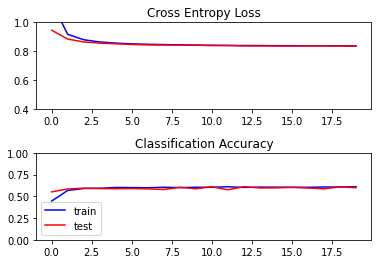

In [17]:
# plot loss as a function of epochs
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.4,1)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 1)
plt.legend()

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

# For comparison convert the loss to log-likelihood and rho^2
hist_loss_train = history.history.get('loss')
LL_final_train = -np.array(hist_loss_train[len(hist_loss_train)-1]) *len(Y_train)
print('Cross-entropy training data at final epoch  = ', "{:.3f}".format(hist_loss_train[len(hist_loss_train)-1]))
print('Log-likelihood training data at final epoch = ', "{:.1f}".format(LL_final_train))
print('rho square training data at final epoch     = ', "{:.2f}".format(1 - LL_final_train / -(len(Y_train)*np.log(3))))
print()

hist_loss_test = history.history.get('val_loss')
LL_final_test = -np.array(hist_loss_test[len(hist_loss_test)-1]) *len(Y_test)
print('Cross-entropy test data at final epoch     = ', "{:.3f}".format(hist_loss_test[len(hist_loss_test)-1]))
print('Log-likelihood test data at final epoch    = ', "{:.1f}".format(LL_final_test))
print('rho square test data at final epoch        = ', "{:.2f}".format(1 - LL_final_test / -(len(Y_test)*np.log(3))))

<font color='red'>

**ANSWER Q4** <br>

The cross-entropy of the hybrid model on the test data = 0.836 <br>
The cross entropy of the DCM                           = 0.889 <br>
Hence, the hybrid model improves the performance, albeit not so dramatically

### Q5. Compute the WtP of the average decision maker to reduce the share of foreigners in a neighbourhood by 1 percentage point using the results from the hybrid model. Compare the outcome with the results of your discrete choice model (0.5 pts)

In [18]:
# Show the trained taste parameters, from the MNL part
beta_distSTORES = np.squeeze((betas[0][0]))
beta_shareFOREIGN = np.squeeze((betas[0][1]))
print('Beta_distSTORES     = ', "{:.3f}".format(beta_distSTORES )) 
print('Beta_shareFOREIGN = ', "{:.3f}".format(beta_shareFOREIGN ))

# Compute the Willingness to Pay for a Gb extra storage space
WtP = beta_shareFOREIGN/(beta_distSTORES*100)
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP),'minutes per percentage point decrease in share of foreigners')
print()

Beta_distSTORES     =  -0.039
Beta_shareFOREIGN =  -1.047
The WtP to reduce the share of foreigners =  0.27 minutes per percentage point decrease in share of foreigners



<font color='red'>

**ANSWER Q5** <br>
    
The WtP to reduce the share of foreigners is ~0.4 minutes per percentage point decrease in the share of foreigners.
This is slightly higher that the DCM, but reasonably so. Still in the same order of magnitude.

### Q6. Explore whether, or not, the preferences of the inhabitants of the four cities regarding the trade-off between share of foreigners and distance to grocery stores are equal across the four cities. (1.5 pts)

Perform a series of (clever) analyses, and interpret the findings. In other words, can we conclude that the inhabintants of all cities are equally xenophobic? For these analysis, use hybrid models, and/or DCMs.

**Hint:** create new features capturing for the share of foreigners *per city*. 

In [ ]:
NALT = 3           # Number of alterantives in the data set.
no_X_MNL =   5     # Number of attributes with behavioural interest (-->MNL model part). In this case distStores (1) & foreigner share PER city (4)
no_X_ANN = 3*4+3   # Number of features without behavioural interest (-->ANN model part). 
num_nodes = 5      # Number of nodes in hidden layer(s). Again we use 2 hidden layers with *num_nodes* nodes each
nEpoch = 20        # Number epochs for training (max). 

# INPUT FOR MNL PART
X_MNL = Input((no_X_MNL, NALT,1), name = 'Features2MNL')

# COMPUTE UTILITY FOR MNL
V_MNL = Conv2D(filters = 1, kernel_size = [no_X_MNL,1], strides = (1,1), padding = 'valid', name = 'MNL_layer', use_bias = False, trainable = True)(X_MNL)

# INPUT FOR ANN PART
X_ANN = Input((no_X_ANN), name ='Features2ANN')

# CREATE HIDDEN LAYER(S) OF ANN
layer1_ANN = Dense(units = num_nodes, name = "ANN_layer1", use_bias = True)(X_ANN)           # In the original code Convoultion later was used here. That seems incorrect to me
layer2_ANN = Dense(units = num_nodes, name = "ANN_layer2", use_bias = True)(layer1_ANN)

# COMPUTE UTILITY FOR ANN 
V_ANN = Dense(units = NALT, name = "V_ANN")(layer2_ANN)

# RESHAPE TENSORS TO [1 X NALT]
V_MNL = Reshape([NALT], name = 'Flatten_Dim_MNL')(V_MNL)
V_ANN = Reshape([NALT], name = 'Flatten_Dim_ANN')(V_ANN) 

# SUM THE UTILITIES OF BOTH MODEL PARTS
V_MNL_ANN = Add(name = "Combining_Vs")([V_MNL,V_ANN])

# CREATE LOGIT (AKA SOFTMAX ) OUTPUT LAYER
logits = Activation('softmax', name = 'Probability')(V_MNL_ANN)

# BUILD THE MODEL
model = Model(inputs = [X_MNL, X_ANN], outputs = logits)

In [ ]:
scale = 1
# Create interactions for the feature FOREIGNER with the CITY
XF1S1 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),1)
XF1S2 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),2)
XF1S3 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),3)
XF1S4 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),4)

XF2S1 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),1)
XF2S2 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),2)
XF2S3 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),3)
XF2S4 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),4)

XF3S1 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),1)
XF3S2 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),2)
XF3S3 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),3)
XF3S4 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),4)

# Reshape arrays
XF1S1 = XF1S1.reshape(9720,1)
XF1S2 = XF1S2.reshape(9720,1)
XF1S3 = XF1S3.reshape(9720,1)
XF1S4 = XF1S4.reshape(9720,1)

XF2S1 = XF2S1.reshape(9720,1)
XF2S2 = XF2S2.reshape(9720,1)
XF2S3 = XF2S3.reshape(9720,1)
XF2S4 = XF2S4.reshape(9720,1)

XF3S1 = XF3S1.reshape(9720,1)
XF3S2 = XF3S2.reshape(9720,1)
XF3S3 = XF3S3.reshape(9720,1)
XF3S4 = XF3S4.reshape(9720,1)

XS1 = np.array(X['STORES1'])
XS2 = np.array(X['STORES2'])
XS3 = np.array(X['STORES3'])

XS1 = XS1.reshape(9720,1)
XS2 = XS2.reshape(9720,1)
XS3 = XS3.reshape(9720,1)

Xalt1 = np.concatenate((XS1, XF1S1, XF1S2, XF1S3, XF1S4),axis=1)
Xalt2 = np.concatenate((XS2, XF2S1, XF2S2, XF2S3, XF2S4),axis=1)
Xalt3 = np.concatenate((XS3, XF3S1, XF3S2, XF3S3, XF3S4),axis=1)

# Create x input for MNL layer, and rescale
x_mnl_con = np.dstack((Xalt1,Xalt2,Xalt3))
x_mnl_con = np.expand_dims(x_mnl_con,3)
print('shape x_mnl_con =',x_mnl_con.shape)

# Create x input for ANN layer
x_ann = np.array([[X['CITY1'], X['TRANSPORT1'],X['NOISE1'],X['GREEN1'], X['CITY2'], X['TRANSPORT2'],X['NOISE2'],X['GREEN2'],X['CITY3'], X['TRANSPORT3'],X['NOISE3'],X['GREEN3'], X['WOMAN'], X['AGE'], X['ENVCONC']]])
x_ann = np.squeeze(np.swapaxes(x_ann, 0, 2))

# Rescale input for the ANN part
scaler = StandardScaler()  
scaler.fit(x_ann)  
x_ann = scaler.transform(x_ann)  
print('Shape of x_ann',x_ann.shape)

In [ ]:
# Split the data into a training and test part
X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl_con, Y_cat, random_state = 1, test_size = 0.35)
X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
print('Total number of obervations in the data set = ', len(x_mnl))
print('Number of obervations in the training set   = ', len(X_mnl_train))
print('Number of obervations in the test set       = ', len(X_mnl_test))

# COMPILE THE MODEL
model.compile(optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"], loss = 'categorical_crossentropy')
model.summary()

# TRAIN THE NETWORK
early_stopping = EarlyStopping(patience = 4, monitor = 'val_loss')
history = model.fit([X_mnl_train, X_ann_train],Y_train, epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test), callbacks = [early_stopping])

betas_layer = model.get_layer(name = 'MNL_layer')
betas = betas_layer.get_weights()

In [ ]:
# plot loss as a function of epochs
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.4,1)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 1)
plt.legend()

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

# For comparison convert the loss to log-likelihood and rho^2
hist_loss_train = history.history.get('loss')
LL_final_train = -np.array(hist_loss_train[len(hist_loss_train)-1]) *len(Y_train)
print('Cross-entropy training data at final epoch  = ', "{:.3f}".format(hist_loss_train[len(hist_loss_train)-1]))
print('Log-likelihood training data at final epoch = ', "{:.1f}".format(LL_final_train))
print('rho square training data at final epoch     = ', "{:.2f}".format(1 - LL_final_train / -(len(Y_train)*np.log(3))))
print()

hist_loss_test = history.history.get('val_loss')
LL_final_test = -np.array(hist_loss_test[len(hist_loss_test)-1]) *len(Y_test)
print('Cross-entropy test data at final epoch     = ', "{:.3f}".format(hist_loss_test[len(hist_loss_test)-1]))
print('Log-likelihood test data at final epoch    = ', "{:.1f}".format(LL_final_test))
print('rho square test data at final epoch        = ', "{:.2f}".format(1 - LL_final_test / -(len(Y_test)*np.log(3))))

In [ ]:
# Show the trained taste parameters, from the MNL part
beta_distSTORES = np.squeeze((betas[0][0]))
beta_shareFOREIGN_S1 = np.squeeze((betas[0][1]))
beta_shareFOREIGN_S2 = np.squeeze((betas[0][2]))
beta_shareFOREIGN_S3 = np.squeeze((betas[0][3]))
beta_shareFOREIGN_S4 = np.squeeze((betas[0][4]))
print('Beta_distSTORES     = ', "{:.3f}".format(beta_distSTORES )) 
print('Beta_shareFOREIGN_S1 = ', "{:.3f}".format(beta_shareFOREIGN_S1 ))
print('Beta_shareFOREIGN_S2 = ', "{:.3f}".format(beta_shareFOREIGN_S2 ))
print('Beta_shareFOREIGN_S3 = ', "{:.3f}".format(beta_shareFOREIGN_S3 ))
print('Beta_shareFOREIGN_S4 = ', "{:.3f}".format(beta_shareFOREIGN_S4 ))

# Compute the Willingness to Pay for a Gb extra storage space
WtP_S1 = beta_shareFOREIGN_S1/(beta_distSTORES*100)
WtP_S2 = beta_shareFOREIGN_S2/(beta_distSTORES*100)
WtP_S3 = beta_shareFOREIGN_S3/(beta_distSTORES*100)
WtP_S4 = beta_shareFOREIGN_S4/(beta_distSTORES*100)
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S1),'minutes per percentage point decrease in share of foreigners')
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S2),'minutes per percentage point decrease in share of foreigners')
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S3),'minutes per percentage point decrease in share of foreigners')
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S4),'minutes per percentage point decrease in share of foreigners')
print()

<font color='red'>

**ANSWER Q6** <br>

What we see here is that inhabitants in the two german cities are willing to trade-in considerably more travel time to the grovery stores than their german counter parts to reduce the share of foreigners with 1 percentage point. 

In [ ]:
# ALTERNATIVELY, BOTH THE SHARE OF FOREIGNERS AND THE STORES ARE INTERACTED WITH THE CITY. THIS WILL GIVE THE SAME OUTCOMES:

NALT = 3           # Number of alterantives in the data set.
no_X_MNL =   8     # Number of attributes with behavioural interest (-->MNL model part). In this case distStores (1) & foreigner share PER city (4)
no_X_ANN = 3*4+3   # Number of features without behavioural interest (-->ANN model part). 
num_nodes = 5      # Number of nodes in hidden layer(s). Again we use 2 hidden layers with *num_nodes* nodes each
nEpoch = 20        # Number epochs for training (max). 

# INPUT FOR MNL PART
X_MNL = Input((no_X_MNL, NALT,1), name = 'Features2MNL')

# COMPUTE UTILITY FOR MNL
V_MNL = Conv2D(filters = 1, kernel_size = [no_X_MNL,1], strides = (1,1), padding = 'valid', name = 'MNL_layer', use_bias = False, trainable = True)(X_MNL)

# INPUT FOR ANN PART
X_ANN = Input((no_X_ANN), name ='Features2ANN')

# CREATE HIDDEN LAYER(S) OF ANN
layer1_ANN = Dense(units = num_nodes, name = "ANN_layer1", use_bias = True)(X_ANN)           # In the original code Convoultion later was used here. That seems incorrect to me
layer2_ANN = Dense(units = num_nodes, name = "ANN_layer2", use_bias = True)(layer1_ANN)

# COMPUTE UTILITY FOR ANN 
V_ANN = Dense(units = NALT, name = "V_ANN")(layer2_ANN)

# RESHAPE TENSORS TO [1 X NALT]
V_MNL = Reshape([NALT], name = 'Flatten_Dim_MNL')(V_MNL)
V_ANN = Reshape([NALT], name = 'Flatten_Dim_ANN')(V_ANN) 

# SUM THE UTILITIES OF BOTH MODEL PARTS
V_MNL_ANN = Add(name = "Combining_Vs")([V_MNL,V_ANN])

# CREATE LOGIT (AKA SOFTMAX ) OUTPUT LAYER
logits = Activation('softmax', name = 'Probability')(V_MNL_ANN)

# BUILD THE MODEL
model = Model(inputs = [X_MNL, X_ANN], outputs = logits)

In [ ]:
scale = 1

# Create interactions for the feature FOREIGNER with the CITY
XF1S1 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),1)
XF1S2 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),2)
XF1S3 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),3)
XF1S4 = np.array(X['FOREIGN1']) * np.equal(np.array(X['SSTADT']),4)
XF2S1 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),1)
XF2S2 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),2)
XF2S3 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),3)
XF2S4 = np.array(X['FOREIGN2']) * np.equal(np.array(X['SSTADT']),4)
XF3S1 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),1)
XF3S2 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),2)
XF3S3 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),3)
XF3S4 = np.array(X['FOREIGN3']) * np.equal(np.array(X['SSTADT']),4)

# Create interactions for the feature STORES with the CITY
XS1S1 = np.array(X['STORES1']) * np.equal(np.array(X['SSTADT']),1)
XS1S2 = np.array(X['STORES1']) * np.equal(np.array(X['SSTADT']),2)
XS1S3 = np.array(X['STORES1']) * np.equal(np.array(X['SSTADT']),3)
XS1S4 = np.array(X['STORES1']) * np.equal(np.array(X['SSTADT']),4)
XS2S1 = np.array(X['STORES2']) * np.equal(np.array(X['SSTADT']),1)
XS2S2 = np.array(X['STORES2']) * np.equal(np.array(X['SSTADT']),2)
XS2S3 = np.array(X['STORES2']) * np.equal(np.array(X['SSTADT']),3)
XS2S4 = np.array(X['STORES2']) * np.equal(np.array(X['SSTADT']),4)
XS3S1 = np.array(X['STORES3']) * np.equal(np.array(X['SSTADT']),1)
XS3S2 = np.array(X['STORES3']) * np.equal(np.array(X['SSTADT']),2)
XS3S3 = np.array(X['STORES3']) * np.equal(np.array(X['SSTADT']),3)
XS3S4 = np.array(X['STORES3']) * np.equal(np.array(X['SSTADT']),4)

# Reshape arrays
XF1S1 = XF1S1.reshape(9720,1)
XF1S2 = XF1S2.reshape(9720,1)
XF1S3 = XF1S3.reshape(9720,1)
XF1S4 = XF1S4.reshape(9720,1)
XF2S1 = XF2S1.reshape(9720,1)
XF2S2 = XF2S2.reshape(9720,1)
XF2S3 = XF2S3.reshape(9720,1)
XF2S4 = XF2S4.reshape(9720,1)
XF3S1 = XF3S1.reshape(9720,1)
XF3S2 = XF3S2.reshape(9720,1)
XF3S3 = XF3S3.reshape(9720,1)
XF3S4 = XF3S4.reshape(9720,1)

XS1S1 = XS1S1.reshape(9720,1)
XS1S2 = XS1S2.reshape(9720,1)
XS1S3 = XS1S3.reshape(9720,1)
XS1S4 = XS1S4.reshape(9720,1)
XS2S1 = XS2S1.reshape(9720,1)
XS2S2 = XS2S2.reshape(9720,1)
XS2S3 = XS2S3.reshape(9720,1)
XS2S4 = XS2S4.reshape(9720,1)
XS3S1 = XS3S1.reshape(9720,1)
XS3S2 = XS3S2.reshape(9720,1)
XS3S3 = XS3S3.reshape(9720,1)
XS3S4 = XS3S4.reshape(9720,1)

# Concatenate features for MNL part
Xalt1 = np.concatenate((XS1S1, XS1S2, XS1S3, XS1S4, XF1S1, XF1S2, XF1S3, XF1S4),axis=1)
Xalt2 = np.concatenate((XS2S1, XS2S2, XS2S3, XS2S4, XF2S1, XF2S2, XF2S3, XF2S4),axis=1)
Xalt3 = np.concatenate((XS3S1, XS3S2, XS3S3, XS3S4, XF3S1, XF3S2, XF3S3, XF3S4),axis=1)

# Create x input for MNL layer, and rescale
x_mnl_con = np.dstack((Xalt1,Xalt2,Xalt3))
x_mnl_con = np.expand_dims(x_mnl_con,3)
print('shape x_mnl_con =',x_mnl_con.shape)

# Create x input for ANN layer
x_ann = np.array([[X['CITY1'], X['TRANSPORT1'],X['NOISE1'],X['GREEN1'], X['CITY2'], X['TRANSPORT2'],X['NOISE2'],X['GREEN2'],X['CITY3'], X['TRANSPORT3'],X['NOISE3'],X['GREEN3'], X['WOMAN'], X['AGE'], X['ENVCONC']]])
x_ann = np.squeeze(np.swapaxes(x_ann, 0, 2))

# Rescale input for the ANN part
scaler = StandardScaler()  
scaler.fit(x_ann)  
x_ann = scaler.transform(x_ann)  
print('Shape of x_ann',x_ann.shape)

In [ ]:
# Split the data into a training and test part
X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl_con, Y_cat, random_state = 1, test_size = 0.35)
X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
print('Total number of obervations in the data set = ', len(x_mnl))
print('Number of obervations in the training set   = ', len(X_mnl_train))
print('Number of obervations in the test set       = ', len(X_mnl_test))

# COMPILE THE MODEL
model.compile(optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"], loss = 'categorical_crossentropy')
model.summary()

# TRAIN THE NETWORK
early_stopping = EarlyStopping(patience = 4, monitor = 'val_loss')
history = model.fit([X_mnl_train, X_ann_train],Y_train, epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test), callbacks = [early_stopping])

betas_layer = model.get_layer(name = 'MNL_layer')
betas = betas_layer.get_weights()

In [ ]:
# plot loss as a function of epochs
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.4,1)

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 1)
plt.legend()

# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace = 0.5)

# For comparison convert the loss to log-likelihood and rho^2
hist_loss_train = history.history.get('loss')
LL_final_train = -np.array(hist_loss_train[len(hist_loss_train)-1]) *len(Y_train)
print('Cross-entropy training data at final epoch  = ', "{:.3f}".format(hist_loss_train[len(hist_loss_train)-1]))
print('Log-likelihood training data at final epoch = ', "{:.1f}".format(LL_final_train))
print('rho square training data at final epoch     = ', "{:.2f}".format(1 - LL_final_train / -(len(Y_train)*np.log(3))))
print()

hist_loss_test = history.history.get('val_loss')
LL_final_test = -np.array(hist_loss_test[len(hist_loss_test)-1]) *len(Y_test)
print('Cross-entropy test data at final epoch     = ', "{:.3f}".format(hist_loss_test[len(hist_loss_test)-1]))
print('Log-likelihood test data at final epoch    = ', "{:.1f}".format(LL_final_test))
print('rho square test data at final epoch        = ', "{:.2f}".format(1 - LL_final_test / -(len(Y_test)*np.log(3))))

In [ ]:
# Show the trained taste parameters, from the MNL part
beta_distSTORES_S1 = np.squeeze((betas[0][0]))
beta_distSTORES_S2 = np.squeeze((betas[0][1]))
beta_distSTORES_S3 = np.squeeze((betas[0][2]))
beta_distSTORES_S4 = np.squeeze((betas[0][3]))
beta_shareFOREIGN_S1 = np.squeeze((betas[0][4]))
beta_shareFOREIGN_S2 = np.squeeze((betas[0][5]))
beta_shareFOREIGN_S3 = np.squeeze((betas[0][6]))
beta_shareFOREIGN_S4 = np.squeeze((betas[0][7]))
print('Beta_distSTORES_S1   = ', "{:.3f}".format(beta_distSTORES_S1 )) 
print('Beta_distSTORES_S2   = ', "{:.3f}".format(beta_distSTORES_S2 )) 
print('Beta_distSTORES_S3   = ', "{:.3f}".format(beta_distSTORES_S3 )) 
print('Beta_distSTORES_S4   = ', "{:.3f}".format(beta_distSTORES_S4 )) 
print('Beta_shareFOREIGN_S1 = ', "{:.3f}".format(beta_shareFOREIGN_S1 ))
print('Beta_shareFOREIGN_S2 = ', "{:.3f}".format(beta_shareFOREIGN_S2 ))
print('Beta_shareFOREIGN_S3 = ', "{:.3f}".format(beta_shareFOREIGN_S3 ))
print('Beta_shareFOREIGN_S4 = ', "{:.3f}".format(beta_shareFOREIGN_S4 ))

# Compute the Willingness to Pay for a Gb extra storage space
WtP_S1 = beta_shareFOREIGN_S1/(beta_distSTORES_S1*100)
WtP_S2 = beta_shareFOREIGN_S2/(beta_distSTORES_S2*100)
WtP_S3 = beta_shareFOREIGN_S3/(beta_distSTORES_S3*100)
WtP_S4 = beta_shareFOREIGN_S4/(beta_distSTORES_S4*100)
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S1),'minutes per percentage point decrease in share of foreigners')
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S2),'minutes per percentage point decrease in share of foreigners')
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S3),'minutes per percentage point decrease in share of foreigners')
print('The WtP to reduce the share of foreigners = ', "{:.2f}".format(WtP_S4),'minutes per percentage point decrease in share of foreigners')
print()